In [12]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [4]:
DIR_INPUT = "/Users/gputhala/repos/GitHub/lyft_motion_prediction/lyft-motion-prediction-autonomous-vehicles/"
DEBUG = True

In [5]:
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 1,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'train_data_loader': {
        'key': 'scenes/sample.zarr',
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 4
    },
    
    'train_params': {
        'max_num_steps': 1 if DEBUG else 100,
        'checkpoint_every_n_steps': 1,
        'eval_every_n_steps': 1
    }
}

In [6]:
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

In [7]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset,
                              shuffle=train_cfg["shuffle"],
                              batch_size=train_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"])

print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


<b>Model Definition</b>

In [14]:
def build_model(cfg: Dict) -> torch.nn.Module:
    #pre-trained conv2D model
    model = resnet50(pretrained=True)
    
    # input channels to match with rasterized output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False
    )
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)
    
    return model

In [15]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    
    #Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # filtering for only target availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    
    return loss, outputs

<b>Init Model</b>

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)
criterion = nn.MSELoss(reduction="none")

<b>Training</b>

In [20]:
#cv2.setNumThreads(0)
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)
    
    #Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

  0%|          | 0/1 [00:00<?, ?it/s]/Users/gputhala/opt/anaconda3/lib/python3.7/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/Users/gputhala/opt/anaconda3/lib/python3.7/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/Users/gputhala/opt/anaconda3/lib/python3.7/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/Users/gputhala/opt/anaconda3/lib/python3.7/site-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the fut

KeyboardInterrupt: 

Loss Curve

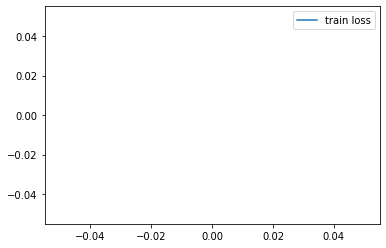

In [21]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()